## Rod Cantilever Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# # save the input file in correct format
# def convert_knot_txt_to_pydismech(in_path: str, out_path: str):
#     """
#     Convert 4-column knot file (x, y, z, theta) into PyDiSMech input format:
#     *Nodes
#     x0, y0, z0
#     ...
#     *Edges
#     1, 2
#     2, 3
#     ...
#     """

#     # Read all non-empty lines
#     with open(in_path, "r") as f:
#         lines = [ln.strip() for ln in f if ln.strip()]

#     num_nodes = len(lines)

#     with open(out_path, "w") as out:
#         # Write nodes
#         out.write("*Nodes\n")
#         for ln in lines:
#             parts = ln.split()
#             if len(parts) < 3:
#                 continue  # skip malformed lines just in case

#             # Take only x, y, z (ignore theta / 4th column)
#             x, y, z = parts[0], parts[1], parts[2]
#             out.write(f"{x}, {y}, {z}\n")

#         # Write edges (sequential rod: 1-2, 2-3, ..., N-1–N)
#         out.write("*Edges\n")
#         for i in range(1, num_nodes):
#             out.write(f"{i}, {i+1}\n")


# convert_knot_txt_to_pydismech("../tests/resources/knot_tying/n1.txt", "../tests/resources/knot_tying/input.txt")



In [3]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [4]:

import numpy as np
characteristicForce = np.pi * pow(0.0016, 4) / 4.0 * 0.18e6 / pow(1, 2)
forceTol = 1e-3 * characteristicForce
print("Force Tolerance: ", forceTol)

Force Tolerance:  9.264933726554733e-10


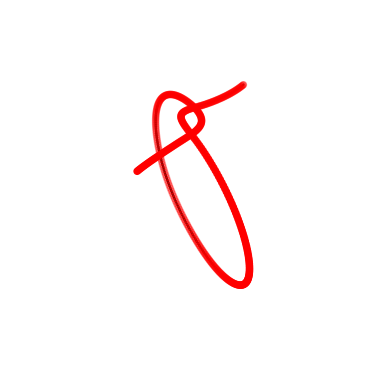

In [5]:
import numpy as np

import dismech

geom = dismech.GeomParams(rod_r0=0.0016,
                          shell_h=0)

material = dismech.Material(density=1180,
                            youngs_rod=0.18e6,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

static_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=True,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-1,
                                  max_iter=10,
                                  total_time=62,
                                  plot_step=1,
                                  tol=1e-3,
                                  ftol=1e-8,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('selfContact', delta=5e-4, h=0.0016, kc=1)
env.add_force('selfFriction', mu=0.3, vel_tol=1e-4)
env.add_force('damping', eta=0.1)

geo = dismech.Geometry.from_txt(
    '../tests/resources/knot_tying/input.txt')

robot = dismech.SoftRobot(geom, material, geo, static_2d_sim, env)

In [6]:
print(np.shape(robot.contact_pairs))
print(robot.edge_combos[0:10])

(44253,)
[[ 0  1  3  4]
 [ 0  1  4  5]
 [ 0  1  5  6]
 [ 0  1  6  7]
 [ 0  1  7  8]
 [ 0  1  8  9]
 [ 0  1  9 10]
 [ 0  1 10 11]
 [ 0  1 11 12]
 [ 0  1 12 13]]


### Time Stepping

Pulling apart simulated using moving boundary condition

In [7]:
pull_speed = 0.006  # m/s
wait_time = 2  # seconds
release_time = 0  # seconds
pull_time = 60  # seconds

In [8]:
start_nodes = [0, 1]
end_nodes = [robot.n_nodes - 1, robot.n_nodes - 2]

robot = robot.fix_nodes(np.union1d(start_nodes, end_nodes))
def pull_and_release(robot: dismech.SoftRobot, t: float):
    """ Simple example of a moving boundary condition """
    u0 = pull_speed

    if t > wait_time and t <= wait_time + pull_time: # pulling phase
        robot = robot.move_nodes(start_nodes, [0, -u0 * robot.sim_params.dt, 0])
        robot = robot.move_nodes(end_nodes, [0, u0 * robot.sim_params.dt, 0])
    elif t > wait_time + pull_time and t <= wait_time + pull_time + release_time: # release phase
        robot = robot.move_nodes(start_nodes, [0, u0 * robot.sim_params.dt, 0])
        robot = robot.move_nodes(end_nodes, [0, -u0 * robot.sim_params.dt, 0])
    
    return robot


stepper = dismech.ImplicitEulerTimeStepper(robot)
stepper.before_step = pull_and_release

robots, t_arr, f_norms = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])
t_arr = np.array(t_arr)

delta: 0.3125
h: 1.0
K1: 48.0
scale:  625.0
kc:  1
upper limit for quadratic: 1.6875
upper limit for smooth: 2.3125
delta: 0.3125
h: 1.0
K1: 48.0
scale:  625.0
kc:  1
upper limit for quadratic: 1.6875
upper limit for smooth: 2.3125
iter: 1, error: 1.628
current_time:  0.1
iter: 1, error: 0.589
iter: 2, error: 0.215
iter: 3, error: 0.079
iter: 4, error: 0.028
iter: 5, error: 0.010
current_time:  0.2
iter: 1, error: 0.004
current_time:  0.30000000000000004
iter: 1, error: 0.001
iter: 2, error: 0.001
current_time:  0.4
iter: 1, error: 0.000
current_time:  0.5
iter: 1, error: 0.000
current_time:  0.6
iter: 1, error: 0.000
current_time:  0.7
iter: 1, error: 0.000
current_time:  0.7999999999999999
iter: 1, error: 0.000
current_time:  0.8999999999999999
iter: 1, error: 0.000
current_time:  0.9999999999999999
iter: 1, error: 0.000
current_time:  1.0999999999999999
iter: 1, error: 0.000
current_time:  1.2
iter: 1, error: 0.000
current_time:  1.3
iter: 1, error: 0.000
current_time:  1.4000000000

In [9]:
from dismech.logging import logDataForRendering
t=t_arr[::1]
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), robot.sim_params.static_sim, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData.js', shell_js='shellData.js',
                          rod_radius=0.06, scaleFactor=10)

(5563, 1204) (5563, 1) (5563, 1203)
(0,)
0


/Users/radha/GitRepos/dismech-python/src/dismech/logging.py:100: UserWarning: loadtxt: input contained no data: "rawDataShell.txt"
  ds = np.loadtxt(shell_file)


In [10]:
print(qs.shape[0])
print(t_arr.shape)
# t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Knot tying', plot_step=100)

fig = dismech.get_interactive_animation_plotly(robot, t_arr, qs, options)
fig.show()

5563
(5563,)


57


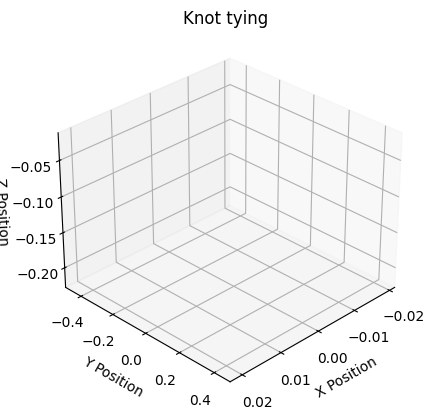

In [11]:
# save gif
ani = dismech.get_animation(robot, t_arr, qs, options)
ani.save('knot.gif')

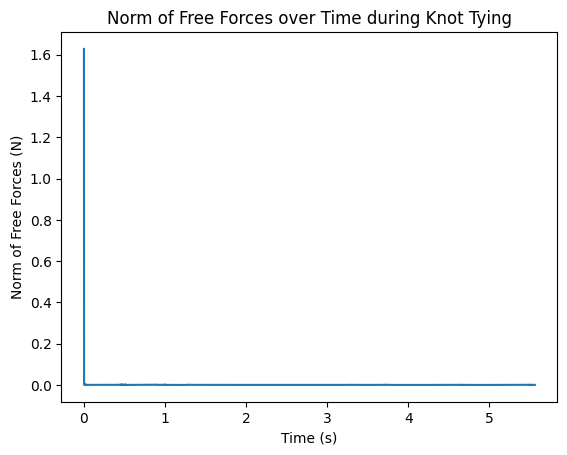

In [12]:
# plot norm of free forces over time
import matplotlib.pyplot as plt
plt.plot(np.arange(len(f_norms)) * robot.sim_params.dt, f_norms)
plt.xlabel('Time (s)')
plt.ylabel('Norm of Free Forces (N)')
plt.title('Norm of Free Forces over Time during Knot Tying')
plt.show()
